In [11]:
%load_ext autoreload
%autoreload 2

## Function to parse url

In [1]:
from newspaper import Article

In [2]:
url = 'http://fox13now.com/2013/12/30/new-year-new-laws-obamacare-pot-guns-and-drones/'

In [50]:
def get_text_title(url):
    article = Article(url)
    article.download()
    article.parse()
    text = article.text
    title = article.title
    return title, text

In [13]:
title, text = get_text_title(url)

## Preprocess

In [19]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def rm_punctuation(tokenized):
    regex = re.compile('[%s]' % re.escape(string.punctuation)) 
    new_tokenized = []
    for token in tokenized:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_tokenized.append(new_token)
    return new_tokenized

def rm_stopwords(words):
    new_words = []
    for word in words:
        if not word in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stemming(words):
    snowball = SnowballStemmer('english')
    new_words = []
    for word in words:
        new_words.append(snowball.stem(word))
    return new_words

def clean_text(text):
    # tokenize
    tokenized = word_tokenize(text)
    punc_rmd = rm_punctuation(tokenized)
    stw_rmd = rm_stopwords(punc_rmd)
    stmd = stemming(stw_rmd)
    new_text = " ".join(stmd)
    return new_text

In [22]:
clean_text(title)

'new year new law obamacar pot gun drone'

## Embedding

In [34]:
import pickle
from keras.preprocessing.sequence import pad_sequences

In [29]:
tokenizer = pickle.load(open("./data/tokenizer.pkl", 'rb'))

Using TensorFlow backend.


In [62]:
def word2indx(text, trained_tokenizer, max_len=2000):
    if isinstance(text, str):
        # single string text
        text = [text]
    tokenizer = trained_tokenizer
    sequences = tokenizer.texts_to_sequences(text)
    data = pad_sequences(sequences, maxlen=max_len)
    return data

In [67]:
inded = word2indx(text, tokenizer)
inded

array([[    0,     0,     0, ..., 18190,   691,     6]], dtype=int32)

## Make prediction

In [69]:
from keras.models import load_model

model = load_model("./data/models/CNN_LSTM2")

In [101]:
def predict_from_index(model, index):
    prediction = model.predict(index).flatten()
    prob_true = prediction[0] * 100
    prob_false = prediction[1] * 100
    if prob_true >= 0.7:
        print("Likely a true news! (%0.3f percent confident)" % prob_true)
    elif prob_true >= 0.5:
        print("Maybe a true news, not every sure (%0.3f percent confident)")
    elif prob_true < 0.5 & prob_true > 0.3:
        print("This is mabye a fake news (%0.3f percent confident)" % prob_false)
    elif prob_false >= 0.7:
        print("Attention! Likely a fake news! (%0.3f percent confident)"% prob_false)
    else:
        print("We are %0.3f percent confident that this is a true news" % prob_true)

In [102]:
predict_from_index(model, inded)

Likely a true news! (99.831 percent confident)


In [103]:
def predict_news(model, url, trained_tokenizer, max_len=2000):
    title, text = get_text_title(url)
    cleaned = clean_text(text)
    index = word2indx(cleaned, trained_tokenizer, max_len)
    predict_from_index(model, index)

In [100]:
predict_news(model, url, tokenizer)

This is likely to be a true news (98.860 percent confident)


## Try out

In [2]:
from src.prediction import predict_news, get_text_title
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [3]:
model = load_model("./data/models/CNN_LSTM2")
tokenizer = pickle.load(open("./data/tokenizer.pkl", 'rb'))                  

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

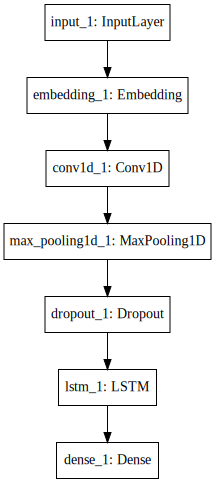

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
auc_val = metrics.auc(fpr_val, tpr_val)
        
#plt.plot(fpr_train, tpr_train,
#        label='Training ROC curve (area = %0.2f)' % auc_train)
plt.plot(fpr_val, tpr_val, 
        label='Validation ROC curve (area = %0.2f)' % auc_val)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc='lower right')
plt.show()

In [6]:
url = "http://www.bbc.com/news/world-latin-america-40391221"
title, text = get_text_title(url)
text

'Image copyright Defensoría del Pueblo de Colombia Image caption The freed journalists (second and third from left) with a delegation of the Colombian Ombudsman\'s Office\n\nTwo Dutch journalists abducted last weekend by rebels in Colombia have been released after a day of conflicting reports about their fate.\n\nDerk Bolt and Eugenio Follender were handed over to a delegation from the Colombian Ombudsman\'s Office, the agency confirmed in a tweet.\n\nNational Liberation Army (ELN) rebels said they had freed them on Friday but later retracted the announcement.\n\nFears were raised for peace talks between the rebels and the government.\n\nImage copyright Defensoría del Pueblo de Colombia Image caption The ELN fighters were heavily armed\n\nHowever, the Dutch pair were finally handed over in a rural area of the Catatumbo region, near the border with Venezuela.\n\nDutch Foreign Minister Bert Koenders welcomed the release as "very good news" and thanked the Colombian authorities for having

In [7]:
predict_news(model, url, tokenizer)

Attention! Likely a fake news! (98.951 percent confident)


## Fake news websites

247NewsMedia.com
http://www.rappler.com/nation/173832-cbcp-list-websites-fake-news

In [67]:
url = "http://abcnews.com.co/specifics-tugboats-maritime-law/"

In [47]:
def predict_text(model, text, trained_tokenizer, max_len=2000):
    cleaned = clean_text(text)
    index = word2indx(cleaned, trained_tokenizer, max_len)
    prediction = model.predict(index).flatten()
    prob_true = float(prediction[0] * 100)
    return prob_true

In [49]:
cd project/news

[Errno 2] No such file or directory: 'project/news'
/data/nasif12/home_if12/chengju/project/news


In [40]:
import pandas as pd
from src.prediction import clean_text, word2indx, predict_from_index 

fkn = pd.read_pickle("./data/fkn.gzip")
texts = fkn["text"]

In [ ]:
y_pred = texts.apply(lambda x: predict_text(model, " ".join(x), tokenizer))

In [ ]:
fkn1 = fkn[y_pred > 80]
texts = fkn1["text"]
texts = texts.apply(lambda x: " ".join(x))

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(texts))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()
plt.savefig("LSTMtrue.png") 